In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
movement_path = './pads-project-main/data/movement/'
tabular_path = './pads-project-main/data/ptables/'

In [3]:
print("Sample movement files:")
print(sorted(os.listdir(movement_path))[:5])

print("\nSample tabular files:")
print(sorted(os.listdir(tabular_path))[:5])

Sample movement files:
['001_ml.bin', '002_ml.bin', '003_ml.bin', '004_ml.bin', '005_ml.bin']

Sample tabular files:
['001_tbl_ml.bin', '002_tbl_ml.bin', '003_tbl_ml.bin', '004_tbl_ml.bin', '005_tbl_ml.bin']


In [4]:
# Evaluate Movement Shape and Structure
mvm_path = './pads-project-main/data/movement/008_ml.bin'


raw = np.fromfile(mvm_path, dtype=np.float32)
print("Total values:", raw.shape[0])

if raw.shape[0] % 6 == 0:
    print("Can reshape into:", raw.shape[0] // 6, "× 6")
    reshaped = raw.reshape((-1, 6))
    print("New shape:", reshaped.shape)
else:
    print("Not divisible by 6 — sensor count mismatch.")

Total values: 128832
Can reshape into: 21472 × 6
New shape: (21472, 6)


In [5]:
tabular_df = pd.read_csv("./pads-project-main/data/tabular_all_patients.csv")
tabular_df["p_id"] = tabular_df["p_id"].apply(lambda x: f"{int(x):03d}")
tabular_df.set_index("p_id", inplace=True)

# Initialize Storage
patient_ids = [f"{i:03d}" for i in range(1, 470)]
X_movement_all = []
X_tabular_all  = []
y_all          = []

for pid in patient_ids:
    mov_file = os.path.join(movement_path, f"{pid}_ml.bin")

    if not os.path.exists(mov_file) or pid not in tabular_df.index:
        continue

    try:
        raw = np.fromfile(mov_file, dtype=np.float32)
        if raw.size != 11 * 1952 * 6:
            print(f"Skipping patient {pid} — unexpected shape")
            continue
        mov_data = raw.reshape(11, 1952, 6)
        X_movement_all.append(mov_data)

        # Load tabular features from CSV
        row = tabular_df.loc[pid]
        keys_to_exclude = ["s_id", "con", "con_lbl", "apprifgk", "effal"]
        features = row.drop(keys_to_exclude).values.astype(np.float32)
        X_tabular_all.append(features)

        # Load label
        y_all.append(int(row["con_lbl"]))

    except Exception as e:
        print(f"Error loading patient {pid}: {e}")

# Convert to arrays
X_movement_all = np.array(X_movement_all)  # (N, 11, 1952, 6)
X_tabular_all  = np.array(X_tabular_all)   # (N, num_tab_features)
y_all          = np.array(y_all)           # (N,)

print(f"Loaded: movement={X_movement_all.shape}, tabular={X_tabular_all.shape}, labels={y_all.shape}")

Loaded: movement=(469, 11, 1952, 6), tabular=(469, 37), labels=(469,)


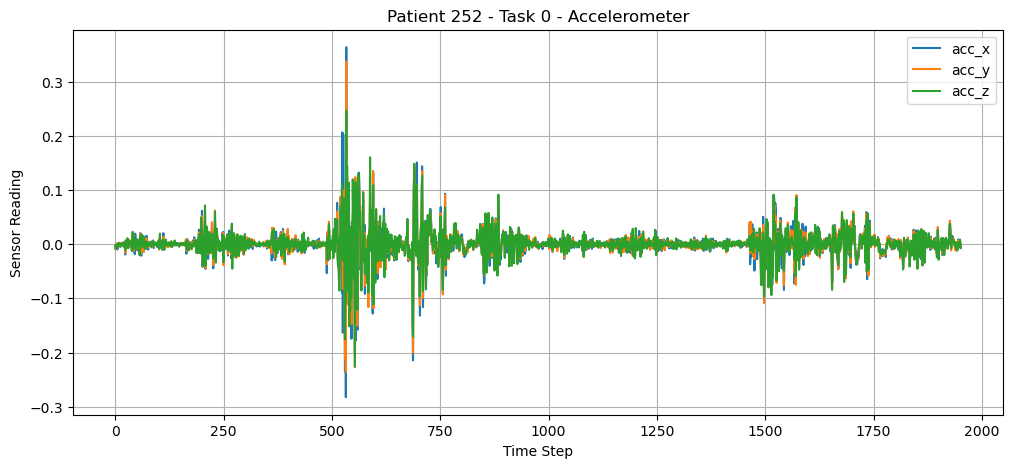

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: X_movement_all.shape = (N, 11, 1952, 6)
patient_idx = 252     # e.g. first patient
task_idx = 0       # e.g. first task
sensor_id = 0     # 0:ACC, 1:GYRO

sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']


sensor_labels = {
    0: ['acc_x', 'acc_y', 'acc_z'],
    1: ['gyro_x', 'gyro_y', 'gyro_z']
}

start_col = 0 if sensor_id == 0 else 3
data = X_movement_all[patient_idx, task_idx, :, start_col:start_col + 3]

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(data[:, i], label=sensor_labels[sensor_id][i])

sensor_name = "Accelerometer" if sensor_id == 0 else "Gyroscope"
plt.title(f"Patient {patient_idx:03d} - Task {task_idx} - {sensor_name}")
plt.xlabel("Time Step")
plt.ylabel("Sensor Reading")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print("NaNs in movement:", np.isnan(X_movement_all).sum())
print("Infs in movement:", np.isinf(X_movement_all).sum())
print("NaNs in tabular:", np.isnan(X_tabular_all).sum())
print("Infs in tabular:", np.isinf(X_tabular_all).sum())

NaNs in movement: 0
Infs in movement: 0
NaNs in tabular: 0
Infs in tabular: 0


In [11]:
print(f"Mov. Max: {np.max(X_movement_all):.3f}\nMov. Min.: {np.min(X_movement_all):.3f}\nMov. Avg.: {np.mean(X_movement_all):.3f}")
print(f"Tab. Max: {np.max(X_tabular_all):.3f}\nTab. Min.: {np.min(X_tabular_all):.3f}\nTab. Avg.: {np.mean(X_tabular_all):.3f}")

Mov. Max: 47.052
Mov. Min.: -48.059
Mov. Avg.: 0.000
Tab. Max: 203.000
Tab. Min.: -1.000
Tab. Avg.: 9.735


In [12]:
from sklearn.preprocessing import StandardScaler

scaler_mov = StandardScaler()
X_movement_all = scaler_mov.fit_transform(
    X_movement_all.reshape(-1, 6)  # flatten all samples/time/axes
).reshape(-1, 11, 1952, 6)         # restore shape

In [13]:
X_movement_all.shape

(469, 11, 1952, 6)

In [14]:
scaler_tab = StandardScaler()
X_tabular_all = scaler_tab.fit_transform(X_tabular_all)

In [15]:
X_tabular_all.shape

(469, 37)

In [16]:
print(f"Mov. Max: {np.max(X_movement_all):.3f}\nMov. Min.: {np.min(X_movement_all):.3f}\nMov. Avg.: {np.mean(X_movement_all):.3f}")
print(f"Tab. Max: {np.max(X_tabular_all):.3f}\nTab. Min.: {np.min(X_tabular_all):.3f}\nTab. Avg.: {np.mean(X_tabular_all):.3f}")

Mov. Max: 47.052
Mov. Min.: -48.059
Mov. Avg.: 0.000
Tab. Max: 5.537
Tab. Min.: -10.924
Tab. Avg.: -0.000


In [17]:
from sklearn.model_selection import train_test_split

X_mov_train, X_mov_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_movement_all, X_tabular_all, y_all,
    test_size=0.2, stratify=y_all, random_state=42
)

In [247]:
# #(Optional) Class Weights for Imbalance
# import torch

# class_counts = torch.tensor(np.bincount(y_train), dtype=torch.float)
# class_weights = (class_counts.sum() / class_counts).to(device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)


In [116]:
import torch
from torch.utils.data import Dataset

class PADSDataset(Dataset):
    def __init__(self, x_mov, x_tab, y):
        self.x_mov = torch.tensor(x_mov, dtype=torch.float32)
        self.x_tab = torch.tensor(x_tab, dtype=torch.float32)
        self.y     = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_mov[idx], self.x_tab[idx], self.y[idx]


In [117]:
from torch.utils.data import DataLoader

# Wrap in PADSDataset
train_dataset = PADSDataset(X_mov_train, X_tab_train, y_train)
val_dataset   = PADSDataset(X_mov_val, X_tab_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ DataLoaders ready: {len(train_loader)} training batches, {len(val_loader)} validation batches")


✅ DataLoaders ready: 12 training batches, 3 validation batches


In [118]:
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [110]:
# Model 1

class TSBERTModel(nn.Module):
    def __init__(self, tabular_dim, num_classes=3):
        super(TSBERTModel, self).__init__()

        # CNN to reduce dimensionality before Transformer
        self.cnn = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)  # (B*T, 32, 976)
        )

        # Transformer block
        encoder_layer = TransformerEncoderLayer(d_model=32, nhead=4, dropout=0.1, batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)

        # Tabular MLP
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(64 + 32, 128),  # 32 from TS-BERT, 64 from tabular
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_mov, x_tab):
        B, T, L, C = x_mov.shape
        x_mov = x_mov.view(B * T, L, C).permute(0, 2, 1)  # (B*T, 6, 1952)

        x_cnn = self.cnn(x_mov)               # (B*T, 32, 976)
        x_cnn = x_cnn.permute(0, 2, 1)        # (B*T, 976, 32)

        x_trans = self.transformer(x_cnn)     # (B*T, 976, 32)
        x_trans = x_trans.mean(dim=1)         # mean pooling → (B*T, 32)

        x_trans = x_trans.view(B, T, -1).mean(dim=1)  # (B, 32)

        x_tab_out = self.tabular_net(x_tab)   # (B, 64)

        fused = torch.cat([x_trans, x_tab_out], dim=1)
        return self.fusion(fused)


In [119]:
#MODEL 2

class TSBERTModel(nn.Module):
    def __init__(self, tabular_dim, num_classes=3):
        super(TSBERTModel, self).__init__()

        # CNN to reduce dimensionality before Transformer
        self.cnn = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)  # (B*T, 32, 976)
        )

        # Transformer block
        encoder_layer = TransformerEncoderLayer(d_model=32, nhead=4, dropout=0.1, batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)

        # Tabular MLP
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(64 + 32, 128),  # 32 from TS-BERT, 64 from tabular
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
        # weight more informative tasks
        self.task_attn = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x_mov, x_tab):
        B, T, L, C = x_mov.shape
        x_mov = x_mov.view(B * T, L, C).permute(0, 2, 1)  # (B*T, 6, 1952)

        x_cnn = self.cnn(x_mov)               # (B*T, 32, 976)
        x_cnn = x_cnn.permute(0, 2, 1)        # (B*T, 976, 32)

        x_trans = self.transformer(x_cnn)     # (B*T, 976, 32)
        x_trans = x_trans.mean(dim=1)         # mean pooling per task → (B*T, 32)

        # Task-level attention pooling
        x_task = x_trans.view(B, T, -1)                        # (B, T, 32)
        task_scores = self.task_attn(x_task).squeeze(-1)       # (B, T)
        task_weights = torch.softmax(task_scores, dim=1).unsqueeze(-1)  # (B, T, 1)
        x_trans = torch.sum(task_weights * x_task, dim=1)      # (B, 32)

        # Tabular
        x_tab_out = self.tabular_net(x_tab)                    # (B, 64)

        # Fusion
        fused = torch.cat([x_trans, x_tab_out], dim=1)         # (B, 96)
        return self.fusion(fused)


In [120]:
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim

# Set up model
tabular_dim = X_tabular_all.shape[1]
model = TSBERTModel(tabular_dim=tabular_dim).to("cuda" if torch.cuda.is_available() else "cpu")

# Loss with optional class weights (replace with your weights if needed)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

device = next(model.parameters()).device


/opt/conda/envs/env_dl/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [121]:
import copy

best_val_f1 = 0.0
patience = 5
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, 31):  # 30 epochs max
    model.train()
    y_true_train, y_pred_train = [], []
    train_loss = 0.0

    for x_mov, x_tab, y in train_loader:
        x_mov, x_tab, y = x_mov.to(device), x_tab.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x_mov, x_tab)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_mov.size(0)  # accumulate properly
        y_pred_train += outputs.argmax(1).tolist()
        y_true_train += y.tolist()

    total_train = len(train_loader.dataset)
    avg_train_loss = train_loss / total_train
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')

    # Validation
    model.eval()
    val_loss = 0.0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for x_mov, x_tab, y in val_loader:
            x_mov, x_tab, y = x_mov.to(device), x_tab.to(device), y.to(device)
            outputs = model(x_mov, x_tab)
            loss = criterion(outputs, y)

            val_loss += loss.item() * x_mov.size(0)
            y_pred_val += outputs.argmax(1).tolist()
            y_true_val += y.tolist()

    total_val = len(val_loader.dataset)
    avg_val_loss = val_loss / total_val
    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')

    # Log metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_f1)

    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
          f"Train F1: {train_f1:.3f} | Val F1: {val_f1:.3f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch 01 | Train Loss: 0.9823 | Train Acc: 0.563 | Val Acc: 0.585 | Train F1: 0.442 | Val F1: 0.432
Epoch 02 | Train Loss: 0.9044 | Train Acc: 0.589 | Val Acc: 0.585 | Train F1: 0.437 | Val F1: 0.432
Epoch 03 | Train Loss: 0.8287 | Train Acc: 0.616 | Val Acc: 0.681 | Train F1: 0.510 | Val F1: 0.615
Epoch 04 | Train Loss: 0.7647 | Train Acc: 0.677 | Val Acc: 0.691 | Train F1: 0.642 | Val F1: 0.681
Epoch 05 | Train Loss: 0.7058 | Train Acc: 0.760 | Val Acc: 0.649 | Train F1: 0.744 | Val F1: 0.615
Epoch 06 | Train Loss: 0.6700 | Train Acc: 0.747 | Val Acc: 0.702 | Train F1: 0.731 | Val F1: 0.682
Epoch 07 | Train Loss: 0.6068 | Train Acc: 0.792 | Val Acc: 0.745 | Train F1: 0.784 | Val F1: 0.733
Epoch 08 | Train Loss: 0.5850 | Train Acc: 0.792 | Val Acc: 0.691 | Train F1: 0.780 | Val F1: 0.688
Epoch 09 | Train Loss: 0.5328 | Train Acc: 0.843 | Val Acc: 0.723 | Train F1: 0.839 | Val F1: 0.712
Epoch 10 | Train Loss: 0.5135 | Train Acc: 0.845 | Val Acc: 0.734 | Train F1: 0.840 | Val F1: 0.726


<All keys matched successfully>

In [122]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name="Model"):
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='orange')
    plt.plot(epochs, val_losses, marker='o', label='Validation Loss', color='orangered')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, marker='o', label='Train Accuracy', color='gold')
    plt.plot(epochs, val_accs, marker='o', label='Validation Accuracy', color='darkorange')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


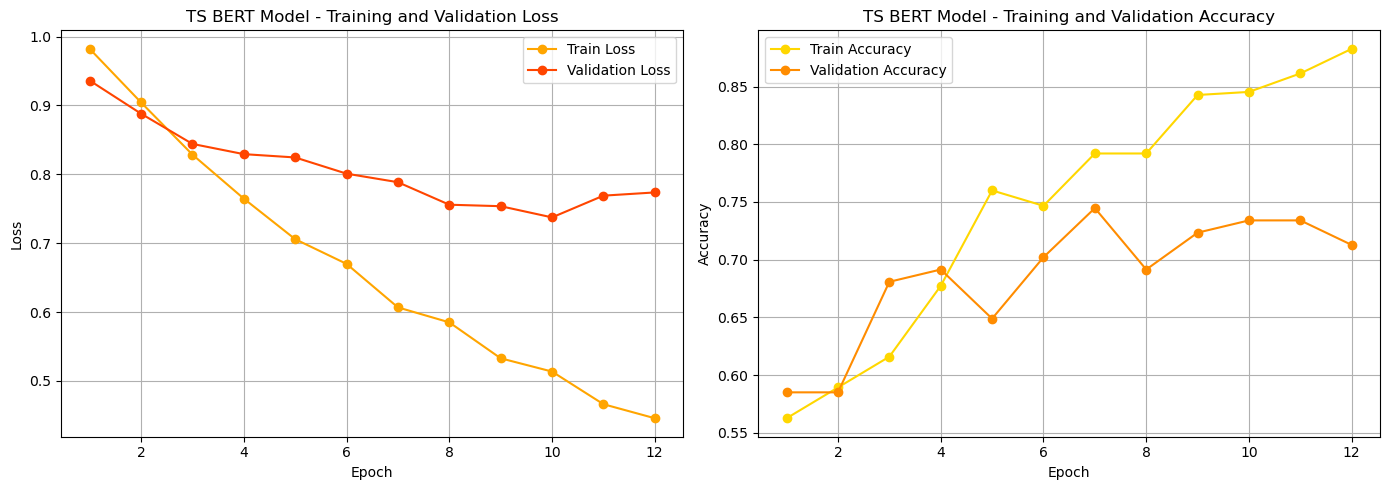

In [123]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name="TS BERT Model")

In [124]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_infer(model, loader, criterion, device, print_report=False):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []

    labels = [0, 1, 2]
    target_names = ["Healthy", "PD", "DD"]

    with torch.no_grad():
        for x_mov, x_tab, y in loader:
            x_mov, x_tab, y = x_mov.to(device), x_tab.to(device), y.to(device)
            out = model(x_mov, x_tab)
            loss = criterion(out, y)

            total_loss += loss.item() * x_mov.size(0)
            correct += (out.argmax(1) == y).sum().item()

            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    if print_report:
        print("\n📊 Classification Report:")
        print(classification_report(all_labels, all_preds, digits=4,
                                    labels=labels, target_names=target_names))

        print("\n🧮 Confusion Matrix:")
        cm = confusion_matrix(all_labels, all_preds, labels=labels)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)



📊 Classification Report:
              precision    recall  f1-score   support

     Healthy     0.6316    0.7500    0.6857        16
          PD     0.7742    0.8727    0.8205        55
          DD     0.7692    0.4348    0.5556        23

    accuracy                         0.7447        94
   macro avg     0.7250    0.6858    0.6873        94
weighted avg     0.7487    0.7447    0.7327        94


🧮 Confusion Matrix:


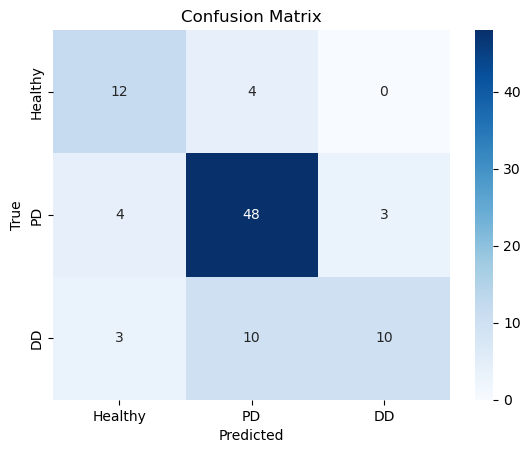

In [125]:
val_loss, val_acc = evaluate_infer(model, val_loader, criterion, device, print_report=True)

In [126]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_multiclass_roc(model, dataloader, device, class_names=["Healthy", "PD", "DD"]):
    model.eval()
    n_classes = len(class_names)
    
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x_mov, x_tab, y in dataloader:
            x_mov, x_tab = x_mov.to(device), x_tab.to(device)
            outputs = model(x_mov, x_tab)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    # Stack all batches
    all_labels = np.concatenate(all_labels)              # shape: (N,)
    all_probs = np.concatenate(all_probs, axis=0)        # shape: (N, num_classes)

    # One-hot encode true labels
    y_bin = label_binarize(all_labels, classes=list(range(n_classes)))  # shape: (N, C)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


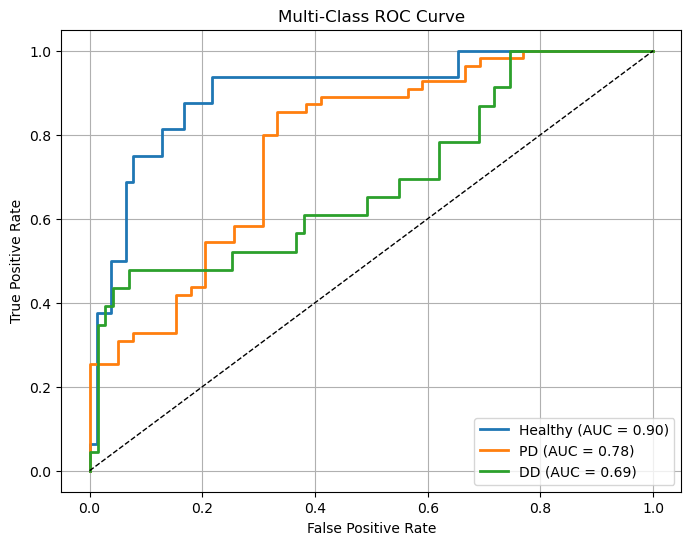

In [127]:
plot_multiclass_roc(model, val_loader, device, class_names=["Healthy", "PD", "DD"])